# Build regression models

In [41]:
import numpy as np
import pandas as pd
import os
import pickle
from joblib import Parallel, delayed
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor

d = './raw_data/'

In [9]:
# Import data
with open('processed_data/analysis_build.pkl', 'rb') as filename:  
    processed_data = pickle.load(filename)

In [90]:
predictors = ['runtime', 
              'is_Winter_Holiday', 'is_Summer', 'is_Awards', 'is_Spring', 'is_Fall',
              'adjusted_budget',
              'avg_wroi_director_id_1','avg_wroi_director_id_2', 'avg_wroi_director_id_3',
              'avg_wroi_actor_id_1', 'avg_wroi_actor_id_2', 'avg_wroi_actor_id_3',
              'avg_wroi_genre_name_1', 'avg_wroi_genre_name_2', 'avg_wroi_genre_name_3', 
              'avg_wroi_production_company_1',# 'avg_wroi_production_company_2', 'avg_wroi_production_company_3',
              'avg_rating_director_id_1', 'avg_rating_director_id_2', 'avg_rating_director_id_3', 
              'avg_rating_actor_id_1', 'avg_rating_actor_id_2', 'avg_rating_actor_id_3',
              'avg_rating_genre_name_1', 'avg_rating_genre_name_2','avg_rating_genre_name_3', 
              'avg_rating_production_company_1' #,'avg_rating_production_company_2', 'avg_rating_production_company_3'
             ]
outputs = ['wroi']

Need to scale variables, and figure out how to measure performance.

#### Linear regression

-0.2647669494965792
-1.3325127849094542
-0.12296458958494716
-0.09514361312976405
-0.08956074841504558
-0.23745874022815006
0.03271982769119375
0.04419165987797813
-0.07733748527116369
-0.04442985546283329
-0.04623380796165244
-0.07196789234768697
-0.058551138634565625
-0.020348826076748594
0.04876058683442985
0.06850993481739598
0.03927741730054701
0.03503694299697768
0.10066445655753598
0.08602517509163443
-0.1633762184999532
0.08385912231939685
0.11613266606697215
0.11493050525899351
0.0841453289811227
0.10935570613708878
-0.06567770201814382
0.036218550072539046
0.1337997897525558
-0.2741602707052291


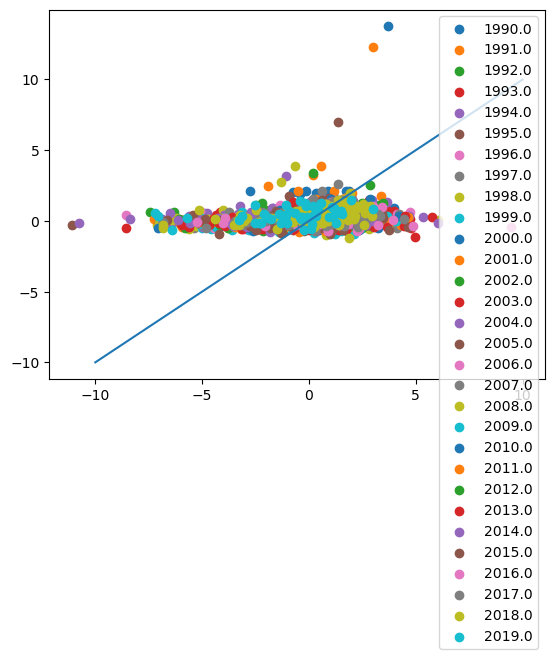

In [92]:
years = np.unique(processed_data.year)

for year in years[:-1]:
    train_data = processed_data.loc[(processed_data.year <= year)]
    test_data = processed_data.loc[processed_data.year == year + 1]
    lr = linear_model.LinearRegression().fit(train_data[predictors], np.log(train_data[outputs]))
    print(lr.score(test_data[predictors], np.log(test_data[outputs])))
    plt.scatter(np.log(test_data[outputs]), lr.predict(test_data[predictors]), label = str(year))

plt.plot(np.linspace(-10, 10, 20), np.linspace(-10, 10, 20))
# plt.semilogy()
# plt.semilogx()
plt.legend()

In [ ]:
# Need to figure out which covariates are most important

### KNN regression

-0.321435489676801
-0.1214064262219885
-0.4830732609927959
0.1141208405710673
0.2761325888060244
-0.32957976652256593
0.5196373377348463
-0.7185016372587436
-0.012634768707868949
-18.475452938433765
-5.843887148275526
-1.3838685610442356
-0.13337025897568822
0.3899888886697651
-0.38469601855585367
-0.061853902333828925
-0.00362401303833626
-0.6278266796010123
-4.231741123294522
-991.0107300013652
-896.5166030717398
-0.8736191722091968
-5.626076841310245
-5.473178792115938
-35.67045151703781
-1062.292854444729
0.14999898347687268
-0.1571777790692186
-0.9336004854467579
-0.8046470008658901


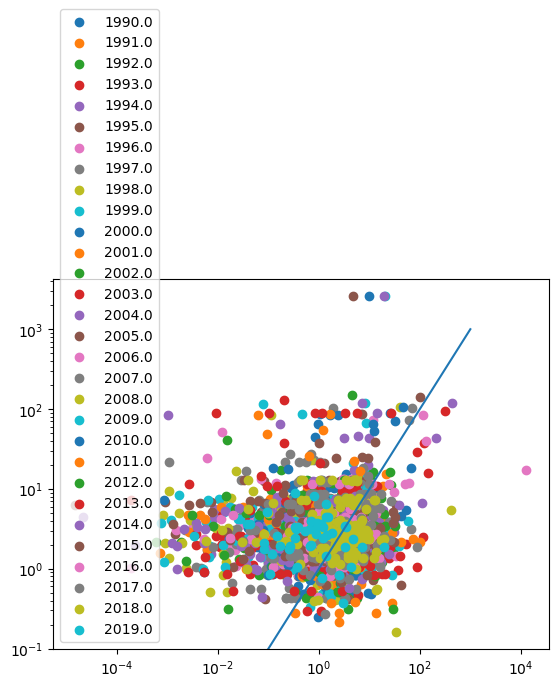

In [71]:
years = np.unique(processed_data.year)

for year in years[:-1]:
    train_data = processed_data.loc[(processed_data.year <= year)]
    test_data = processed_data.loc[processed_data.year == year + 1]
    neigh = KNeighborsRegressor(n_neighbors=5).fit(train_data[predictors], train_data[outputs])
    print(neigh.score(test_data[predictors], test_data[outputs]))
    plt.scatter(test_data[outputs], neigh.predict(test_data[predictors]), label = str(year))

plt.plot(np.linspace(0, 1000, 20), np.linspace(0, 1000, 20))
plt.semilogy()
plt.semilogx()
plt.legend()

### Logistic regression

0.5084745762711864
0.543859649122807
0.4878048780487805
0.4
0.4482758620689655
0.3853211009174312
0.6213592233009708
0.6030534351145038
0.6602564102564102
0.5833333333333334
0.5921052631578947
0.5153374233128835
0.5448275862068965
0.5512820512820513
0.6022099447513812
0.5906735751295337
0.5697674418604651
0.6041666666666666
0.5364238410596026
0.5586592178770949
0.5191256830601093
0.569620253164557
0.5352941176470588
0.5681818181818182
0.5885714285714285
0.5602094240837696
0.5671641791044776
0.5333333333333333
0.4961832061068702
0.1836734693877551


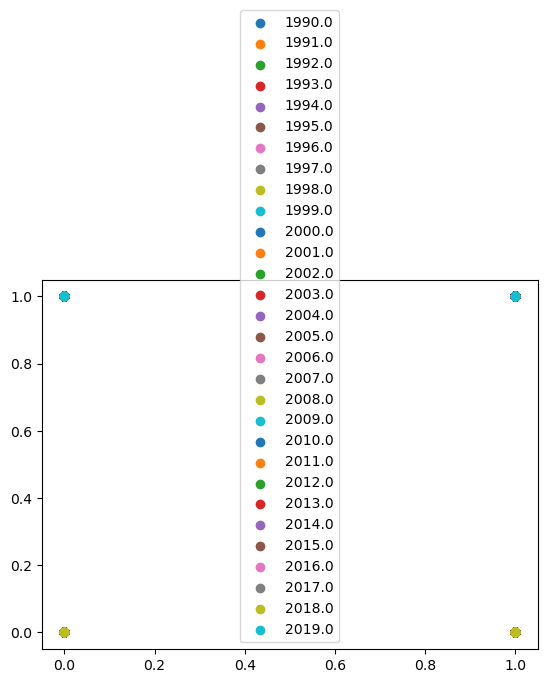

In [72]:
years = np.unique(processed_data.year)

for year in years[:-1]:
    train_data = processed_data.loc[(processed_data.year <= year)]
    test_data = processed_data.loc[processed_data.year == year + 1]
    clf = linear_model.LogisticRegression(random_state=0).fit(train_data[predictors], 
                                                              np.round(1/(1 + np.exp(-(train_data[outputs] - 2)))).values.ravel())
    print(clf.score(test_data[predictors], 
                    np.round(1/(1 + np.exp(-(test_data[outputs] - 2))))) )
    plt.scatter(np.round(1/(1 + np.exp(-(test_data[outputs] - 2)))).values.ravel(), clf.predict(test_data[predictors]), label = str(year))

#plt.plot(np.linspace(0, 1000, 20), np.linspace(0, 1000, 20))
# plt.semilogy()
# plt.semilogx()
plt.legend()